In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
import pathlib
data_dir = pathlib.Path('data/labeled/')

In [3]:
batch_size = 32
img_height = 220
img_width = 300

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
class_names = train_ds.class_names

Found 180 files belonging to 8 classes.
Using 144 files for training.
Found 180 files belonging to 8 classes.
Using 36 files for validation.


2022-08-13 13:28:30.968277: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [5]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [6]:
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1. / 255,
                     input_shape=(img_height, img_width, 3),
                     name='input'),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name='outputs')
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [7]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/10
5/5 [==============================] - 5s 770ms/step - loss: 2.6964 - accuracy: 0.2917 - val_loss: 1.4505 - val_accuracy: 0.6389
Epoch 2/10
5/5 [==============================] - 3s 589ms/step - loss: 1.2967 - accuracy: 0.6042 - val_loss: 1.0523 - val_accuracy: 0.6111
Epoch 3/10
5/5 [==============================] - 3s 607ms/step - loss: 0.7497 - accuracy: 0.8264 - val_loss: 0.4715 - val_accuracy: 0.9444
Epoch 4/10
5/5 [==============================] - 3s 610ms/step - loss: 0.3452 - accuracy: 0.8750 - val_loss: 0.2378 - val_accuracy: 0.9722
Epoch 5/10
5/5 [==============================] - 3s 646ms/step - loss: 0.2463 - accuracy: 0.9306 - val_loss: 0.1678 - val_accuracy: 0.9722
Epoch 6/10
5/5 [==============================] - 3s 627ms/step - loss: 0.1840 - accuracy: 0.9514 - val_loss: 0.0827 - val_accuracy: 0.9722
Epoch 7/10
5/5 [==============================] - 3s 708ms/step - loss: 0.0979 - accuracy: 0.9792 - val_loss: 0.0539 - val_accuracy: 1.0000
Epoch 8/10
5/5 [====

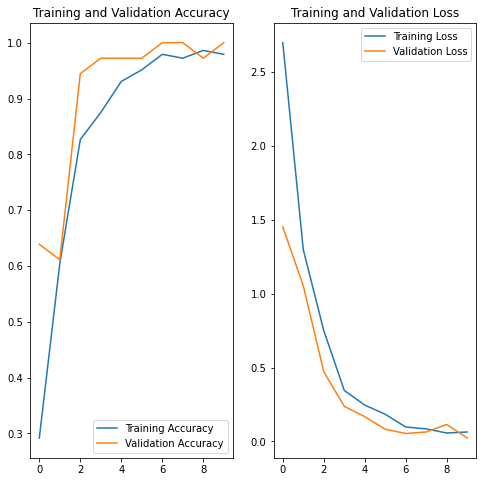

In [8]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [9]:
import json
json.dump(class_names, open('classifier_model/class_names.json', 'w'))

# !mkdir -p classifier_model
# model.save('classifier_model/')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('classifier.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/4t/njkx27c11qq11l5ntlz4j6xh0000gn/T/tmpvsr8zwc_/assets


INFO:tensorflow:Assets written to: /var/folders/4t/njkx27c11qq11l5ntlz4j6xh0000gn/T/tmpvsr8zwc_/assets
2022-08-13 13:29:11.446036: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-08-13 13:29:11.446056: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-08-13 13:29:11.447601: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/4t/njkx27c11qq11l5ntlz4j6xh0000gn/T/tmpvsr8zwc_
2022-08-13 13:29:11.453594: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2022-08-13 13:29:11.453644: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /var/folders/4t/njkx27c11qq11l5ntlz4j6xh0000gn/T/tmpvsr8zwc_
2022-08-13 13:29:11.464562: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-08-13 13:29:11.467207: I tensorflow/cc/saved_model/load